# Dataset analysis
To generate results for every dataset in the `dataset` folder, run:


In [1]:
import matplotlib.pyplot as plt
import re, os
import papermill as pm
%matplotlib inline

In [2]:
# Parameters
input_dir = "dataset/AudioKit"


In [3]:
# Make a regex to extract dataset name
import re

matchObj = re.match( r'.*/(.*)', input_dir, re.M|re.I)
if matchObj:
    dataset_id = matchObj.group(1)
    dataset_id

In [4]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [5]:
# List files in input_dir in natural order
files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]
files = natural_sort(files)
files[0:5]

['dataset/AudioKit/2015_09_21_ba9f2436bf7fcf2367b02534cc616d772a4d9603.csv',
 'dataset/AudioKit/2015_10_30_1e9248a4580ece6946f7db98cd76828eae334dee.csv',
 'dataset/AudioKit/2015_11_30_ad03c37ce9698ace6c33e6d141573059a6ba6cd4.csv',
 'dataset/AudioKit/2015_12_31_38adea1c089c1e77637075c2bf52f9b0702aa401.csv',
 'dataset/AudioKit/2016_01_31_5854c4e951d53697c415109fb583bf4d36aed6c8.csv']

In [6]:
import pandas as pd
n_revisions = len(files)
dfs = [pd.read_csv(file) for file in files]

In [7]:
dfs[0].head()

,id,weight
0,veloperTools/data2yaml.lua,97
1,veloperTools/yaml/fosc.yaml,71
2,veloperTools/yaml/drip.yaml,66
3,veloperTools/yaml/gbuzz.yaml,56
4,veloperTools/yaml/tenv.yaml,48


In [8]:
from functools import reduce
# Outer join of files  
df_full = reduce((lambda x, y: pd.merge(x, y, how='outer', on='id')), dfs)

In [9]:
# Rename columns
df_full.columns = ['id'] + ['t'+str(i) for i in range(df_full.shape[1]-1)]

In [10]:
df_full.head()

,id,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21
0,veloperTools/data2yaml.lua,97.0,98.0,102.0,102.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,veloperTools/yaml/fosc.yaml,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,veloperTools/yaml/drip.yaml,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,veloperTools/yaml/gbuzz.yaml,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,veloperTools/yaml/tenv.yaml,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
from collections import defaultdict
import networkx as nx

FILE_MARKER = '<files>'

def attach(branch, trunk):
    parts = branch.split('/', 1)
    if len(parts) == 1:  # branch is a file
        trunk[FILE_MARKER].append(parts[0])
    else:
        node, others = parts
        if node not in trunk:
            trunk[node] = defaultdict(dict, ((FILE_MARKER, []),))
        attach(others, trunk[node])

def build_adjacency_list(d, id, result):
    for key in d.keys():
        if key != FILE_MARKER:
            result.append((id, id + key))
            build_adjacency_list(d[key], id + key, result)
        else:
            for file in d[key]:
                result.append((id, id + file))

        
def plot_tree(id_list):
    
    keys = sorted(id_list)

    main_dict = defaultdict(dict, ((FILE_MARKER, []),))
    for line in keys:
        attach(line, main_dict)

    # _create adjacency list
    result = []
    build_adjacency_list(main_dict, "ROOT", result)

    G = nx.DiGraph()
    G.add_edges_from(result)
    # write dot file to use with graphviz
    # run "dot -_tpng test.dot >test.png"
    # nx.nx_agraph.write_dot(_g, 'test.dot')

    # same layout using matplotlib with no labels
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=False, arrows=False, node_size=2)



## Union tree of all revisions

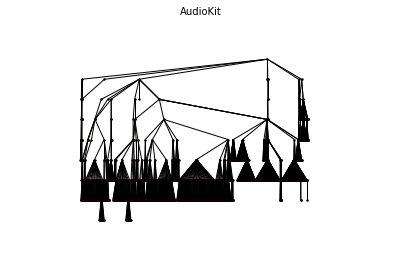

In [12]:
tree_fig = plt.figure(0)
tree_fig.suptitle(dataset_id)
plt.axis('off')
plot_tree(df_full['id'].tolist())
#pm.display('tree', tree_fig)



# Evolution

## Items count

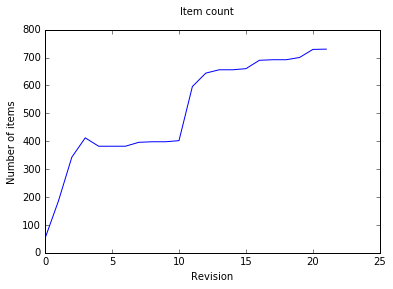

In [13]:
def plot_item_count():
    n_items = [len(df) for df in dfs]
    plt.plot(n_items)

fig = plt.figure()
fig.suptitle("Item count")
plt.ylabel('Number of items')
plt.xlabel('Revision')

plot_item_count()

## Weight count

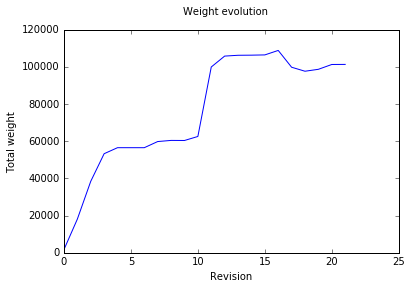

In [14]:
def plot_weight():
    total_weight = [sum(df['weight']) for df in dfs]
    plt.plot(total_weight)

fig = plt.figure()
fig.suptitle("Weight evolution")
plt.ylabel('Total weight')
plt.xlabel('Revision')
plot_weight()

## Addition and removal of items

In [15]:
# How to find removals
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="left_only"')

,id,weight_x,weight_y,_merge
1,veloperTools/yaml/fosc.yaml,71.0,NaN,left_only
2,veloperTools/yaml/drip.yaml,66.0,NaN,left_only
3,veloperTools/yaml/gbuzz.yaml,56.0,NaN,left_only
4,veloperTools/yaml/tenv.yaml,48.0,NaN,left_only
5,veloperTools/yaml/comb.yaml,47.0,NaN,left_only
6,veloperTools/yaml/scale.yaml,42.0,NaN,left_only
7,veloperTools/yaml/pareq-low1.yaml,43.0,NaN,left_only
8,veloperTools/yaml/pareq-peaking0.yaml,43.0,NaN,left_only
9,veloperTools/yaml/pareq-high2.yaml,43.0,NaN,left_only
10,veloperTools/yaml/dist.yaml,39.0,NaN,left_only


In [16]:
# How to find additions
pd.merge(dfs[0], dfs[1], on='id', how='outer', indicator=True).query('_merge=="right_only"')
# len(pd.merge...) to get the number of additions/deletions

,id,weight_x,weight_y,_merge
52,dioKit/AudioKit/Internals/Soundpipe/soundpipe.h,NaN,447.0,right_only
53,dioKit/AudioKit/Internals/Soundpipe/modules/jc...,NaN,327.0,right_only
54,dioKit/AudioKit/Internals/Soundpipe/modules/ft...,NaN,255.0,right_only
55,dioKit/AudioKit/Internals/Soundpipe/modules/re...,NaN,276.0,right_only
56,dioKit/AudioKit/Operations/Signal Generators/O...,NaN,273.0,right_only
57,dioKit/AudioKit/Internals/Soundpipe/modules/ba...,NaN,190.0,right_only
58,dioKit/AudioKit/Operations/Math/AKLinearTransf...,NaN,258.0,right_only
59,dioKit/AudioKit/Operations/Signal Modifiers/Ef...,NaN,258.0,right_only
60,dioKit/AudioKit/Operations/Signal Modifiers/Fi...,NaN,258.0,right_only
61,dioKit/AudioKit/Operations/Signal Modifiers/Fi...,NaN,243.0,right_only


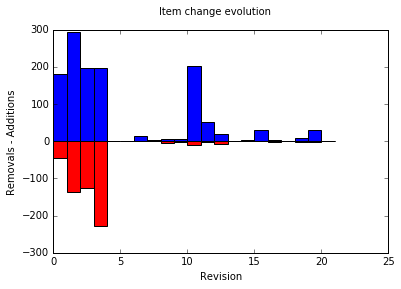

In [17]:
fig, ax = plt.subplots()

n_additions = []
n_removals = []
for i in range(1, n_revisions):
    n_additions.append(
        len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="right_only"')))
    n_removals.append(
        -len(pd.merge(dfs[i-1], dfs[i], on='id', how='outer', indicator=True)
            .query('_merge=="left_only"')))
x = range(0, n_revisions - 1)
ax.bar(x ,n_additions, width=1, color='b')
ax.bar(x, n_removals, width=1, color='r')

fig.suptitle("Item change evolution")
plt.ylabel('Removals - Additions')
plt.xlabel('Revision')



## Sum of cell's change in weight (stability)

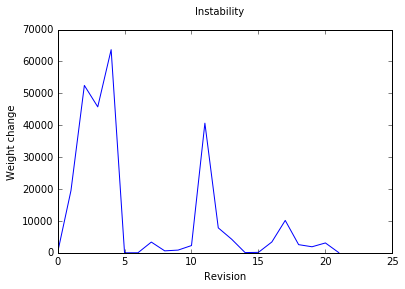

In [18]:
fig = plt.figure()
change = [0.0] * n_revisions
for index, row in df_full.fillna(0).iterrows():
    for j in range (2, len(row)):
        change[j-1] += abs(row[j] - row[j-1])

plt.plot(change)
fig.suptitle("Instability")
plt.ylabel('Weight change')
plt.xlabel('Revision')
    